<a href="https://colab.research.google.com/github/PratikshitSingh/pytorch-tuts/blob/CIFAR-10/pytorch_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
print(torch.__version__)

1.12.1+cu113


Torchvision is a package in the PyTorch library containing computer-vision models, datasets, and image transformations.

Since we want to get the MNIST dataset from the torchvision package, let’s also import the torchvision datasets.



In [2]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

Load data from torchvision & Transform data to tensors

In [3]:
help(datasets)

Help on package torchvision.datasets in torchvision:

NAME
    torchvision.datasets

PACKAGE CONTENTS
    _optical_flow
    caltech
    celeba
    cifar
    cityscapes
    clevr
    coco
    country211
    dtd
    eurosat
    fakedata
    fer2013
    fgvc_aircraft
    flickr
    flowers102
    folder
    food101
    gtsrb
    hmdb51
    imagenet
    inaturalist
    kinetics
    kitti
    lfw
    lsun
    mnist
    omniglot
    oxford_iiit_pet
    pcam
    phototour
    places365
    rendered_sst2
    samplers (package)
    sbd
    sbu
    semeion
    stanford_cars
    stl10
    sun397
    svhn
    ucf101
    usps
    utils
    video_utils
    vision
    voc
    widerface

CLASSES
    torch.utils.data.dataset.Dataset(typing.Generic)
        torchvision.datasets.vision.VisionDataset
            torchvision.datasets.caltech.Caltech101
            torchvision.datasets.caltech.Caltech256
            torchvision.datasets.celeba.CelebA
            torchvision.datasets.cifar.CIFAR10
          

In [22]:
tensor_transform = transforms.ToTensor()

trainset = datasets.cifar.CIFAR10(root='./data', train=True, download=True, transform=tensor_transform)
trainset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [23]:
testset = datasets.cifar.CIFAR10(root='./data', train=False, download=True, transform=tensor_transform)
testset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

Visualize an image from training set

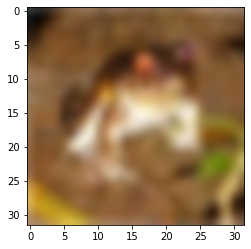

In [6]:
import matplotlib.pyplot as plt

image = trainset[0][0]
label = trainset[0][1]

#image is a (1,28,28) tensor now
plt.imshow(transforms.ToPILImage()(image), interpolation="bicubic")

In [7]:
print(label)

6


Creating mini-batches for training

In [24]:
BATCH_SIZE = 50

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

As found above, data shape is (BACTH_SIZE, N_CHANNELS, WIDTH, HEIGHT). To feed our MLP network, we need to flatten the three last dimensions. We can do so with Tensor.view().

In [9]:
len(trainloader) # 600 batches of 100 datapoints each

1000

In [10]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

images.view(BATCH_SIZE, -1).size() # size of image = 3*32*32

torch.Size([50, 3072])

The tensor is flatterned if we notie

Defining a NN model with linear layers 

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class SequentialMNIST(nn.Module):
    def __init__(self):
        super(SequentialMNIST, self).__init__()
        self.linear1 = nn.Linear(3*32*32, 256)
        self.linear2 = nn.Linear(256, 10)

    def forward(self, x):
        layer1_op = F.relu(self.linear1(x.view(BATCH_SIZE, -1)))
        y_pred = self.linear2(layer1_op)
        return y_pred

In [16]:
model = SequentialMNIST()
model

SequentialMNIST(
  (linear1): Linear(in_features=3072, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=10, bias=True)
)

In [17]:
from torch.autograd import Variable
from tqdm import tqdm

def train(model, trainloader, criterion, optimizer, n_epochs=2):
    for t in range(n_epochs):
      with tqdm(trainloader, unit="batch") as tepoch:
        for i, data in enumerate(tepoch):
          inputs, labels = data
          inputs, labels = Variable(inputs), Variable(labels)

          optimizer.zero_grad()

          outputs = model(inputs)
          loss = criterion(outputs, labels) # Compute the loss
          loss.backward() # Compute the gradient for each variable
          optimizer.step() # Update the weights according to the computed gradientw

In [18]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)
train(model, trainloader, criterion, optimizer, 10)

100%|██████████| 1000/1000 [00:14<00:00, 69.52batch/s]


In [25]:
def predict(model, images):
    outputs = model(Variable(images))
    _, predicted = torch.max(outputs.data, 1)  # TODO: explain why 1
    return predicted

In [26]:
import numpy as np

def show_batch(batch):
    im = torchvision.utils.make_grid(batch)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

Prediction:  tensor([5, 8, 8, 8, 5, 6, 5, 6, 5, 8, 0, 9, 5, 8, 8, 8, 5, 3, 8, 5, 0, 7, 0, 6,
        2, 9, 6, 9, 0, 6, 6, 2, 5, 2, 9, 5, 2, 9, 9, 5, 0, 6, 9, 6, 8, 8, 5, 8,
        4, 6])


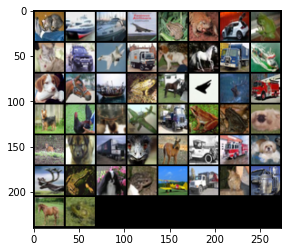

In [27]:
dataiter = iter(testloader)
images, labels = dataiter.next()

show_batch(images)
print('Prediction: ', predict(model, images))

In [28]:
def test(model, testloader, n):
    correct = 0
    for data in testloader:
        inputs, labels = data
        pred = predict(model, inputs)
        correct += (pred == labels).sum()
    return 100 * correct / n

print('Accuracy: ', test(model, testloader, len(testset)))

Accuracy:  tensor(31.4800)


# Convolution layers implementation

In [41]:
class CNNMNIST(nn.Module):
  def __init__(self):
    super(CNNMNIST, self).__init__()
    
    kernel_size   = 3
    
    self.conv1    = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=kernel_size, stride=1, padding=0, dilation=1)    
    self.pool     = nn.MaxPool2d(3, 3)    
    self.conv2    = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=kernel_size, stride=1, padding=1, dilation=1)

    self.fc1      = nn.Linear(3200, 256)
    self.fc2      = nn.Linear(256,10)

  def reshape_for_conv_layer(self, x):
    batch_size = x.shape[0]
    return torch.reshape(x, (BATCH_SIZE, 3, 32, 32))

  def forward(self, x):
    x               = self.reshape_for_conv_layer(x)
    conv1_output    = F.leaky_relu(self.conv1(x))
    pool_output     = F.leaky_relu(self.pool(conv1_output))
    conv2_output    = F.leaky_relu(self.conv2(pool_output))
    flattern        = torch.flatten(conv2_output, 1)
    fc1_output      = F.leaky_relu(self.fc1(flattern))
    fc2_output      = self.fc2(fc1_output)
    output          = F.log_softmax(fc2_output, dim=1)
    return output

In [42]:
model = CNNMNIST()
model

CNNMNIST(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3200, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [43]:
from torch.autograd import Variable
from tqdm import tqdm

def train(model, trainloader, criterion, optimizer, n_epochs=2):
    for t in range(n_epochs):
      with tqdm(trainloader, unit="batch") as tepoch:
        for i, data in enumerate(tepoch):
          inputs, labels = data
          inputs, labels = Variable(inputs), Variable(labels)

          optimizer.zero_grad()

          outputs = model(inputs)
          loss = criterion(outputs, labels) # Compute the loss
          loss.backward() # Compute the gradient for each variable
          optimizer.step() # Update the weights according to the computed gradientw

In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train(model, trainloader, criterion, optimizer, 50)

100%|██████████| 1000/1000 [00:28<00:00, 35.49batch/s]


In [49]:
def predict(model, images):
    outputs = model(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    return predicted

In [50]:
def show_batch(batch):
    im = torchvision.utils.make_grid(batch)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

Prediction:  tensor([3, 1, 0, 0, 4, 6, 1, 6, 3, 1, 4, 9, 5, 7, 9, 8, 5, 7, 8, 6, 1, 2, 4, 9,
        4, 2, 4, 0, 9, 6, 6, 2, 4, 5, 9, 9, 4, 9, 9, 5, 4, 6, 3, 6, 0, 9, 5, 3,
        7, 4])


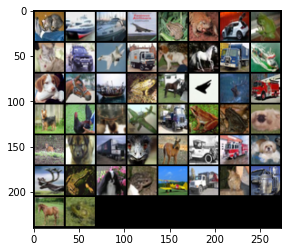

In [51]:
dataiter = iter(testloader)
images, labels = dataiter.next()

show_batch(images)
print('Prediction: ', predict(model, images))

In [52]:
def test(model, testloader, n):
    correct = 0
    for data in testloader:
        inputs, labels = data
        pred = predict(model, inputs)
        correct += (pred == labels).sum()
    return 100 * correct / n

print('Accuracy: ', test(model, testloader, len(testset)))

Accuracy:  tensor(69.2800)
